In [2]:
import sys
import os

# Ajouter le répertoire courant au chemin de recherche des modules
sys.path.append(os.path.abspath(os.getcwd()))

import torch
from KAN import KAN
from kan_ckpt import kan_saveckpt, kan_loadckpt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets

from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

device = 'cuda' if torch.cuda.is_available() else 'cpu'

Testing with linear synthetic data (monotone data)

In [7]:
# linear function
def linear(X, a, b):
    return b + torch.matmul(X, a)


n_samples = 500

X = torch.linspace(0, 1, n_samples).view(-1, 1).repeat(1, 8)

# Coefficients and intercept for the linear function
b = 3
a = torch.tensor([2.5, -1, -3, 1.2, -0.5, 0.8, -2.0, 1.7])

X_transformed = torch.cat([
    X[:, 0].view(-1, 1), 
    X[:, 1].view(-1, 1), 
    X[:, 2].view(-1, 1),
    X[:, 3].view(-1, 1),
    X[:, 4].view(-1, 1),
    X[:, 5].view(-1, 1),
    X[:, 6].view(-1, 1),
    X[:, 7].view(-1, 1)
], dim=1)


y = linear(X_transformed, a, b)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X.numpy(), y.numpy(), test_size=0.2, random_state=42)


In [8]:
# transforming the data 
train_input = torch.tensor(X_train, dtype=torch.float32).to(device)
train_label = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
val_input = torch.tensor(X_val, dtype=torch.float32).to(device)
val_label = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device)

In [9]:
model = KAN(width=[8, 1], grid=7, k=3, seed=0)  

In [10]:
results = model.train(
    {'train_input': train_input, 'train_label': train_label, 'test_input': val_input, 'test_label': val_label},
    opt="LBFGS", steps=10, stop_grid_update_step=50,
    lamb=0, lamb_l1=0.01, lamb_entropy=0,
    loss_fn=torch.nn.MSELoss(), # MSELoss for regression
    lr= 1e-4, batch=25
)

train loss: 5.67e+01 | test loss: 6.45e+01 | reg: 8.96e-01 : 100%|██| 10/10 [04:16<00:00, 25.66s/it]


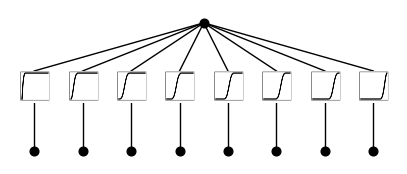

In [11]:
model.plot(beta=1000)

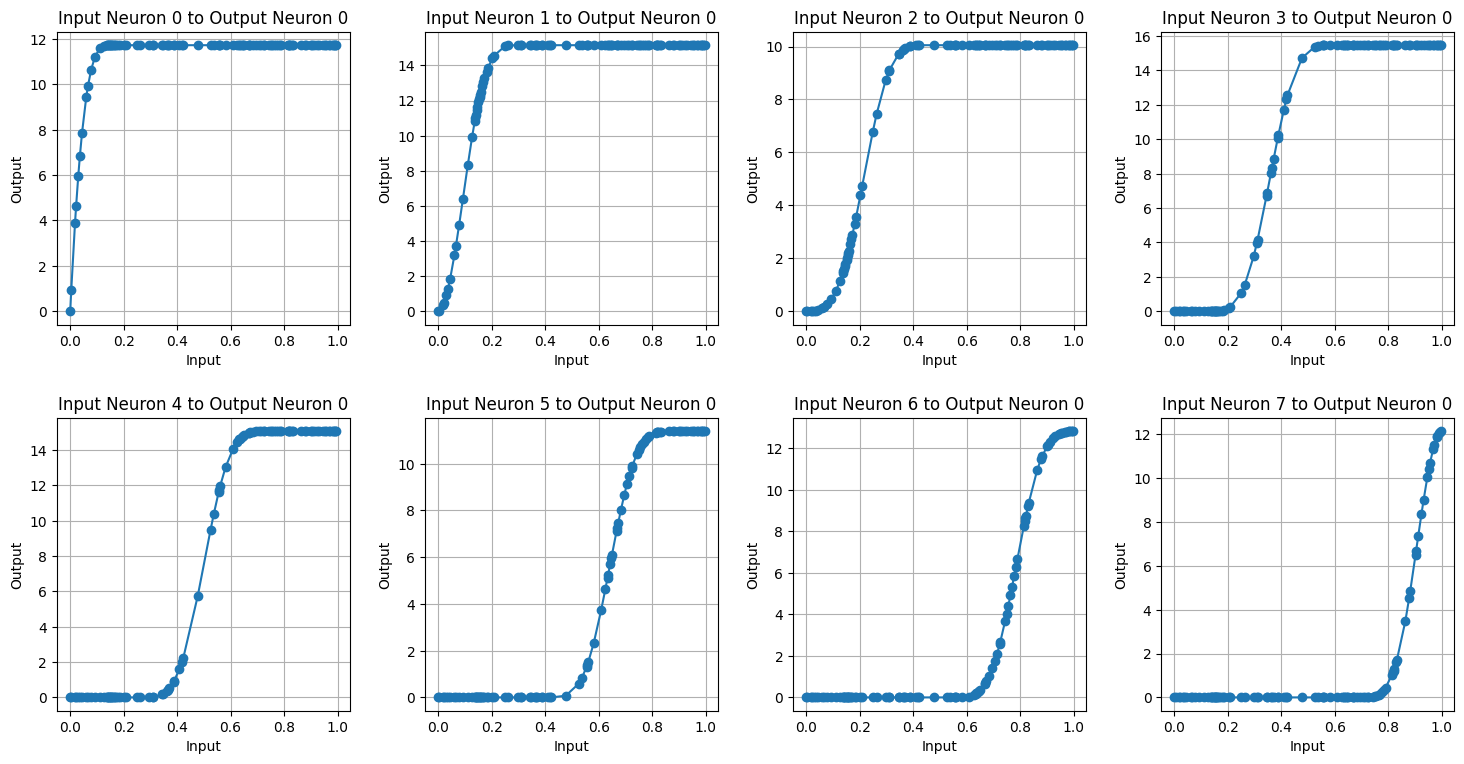

In [12]:
# 8 input neurons
input_neurons = [0, 1, 2, 3, 4, 5, 6, 7]
output_neuron = 0  
layer_index = 0  

rows = 2
cols = 4  

fig, axs = plt.subplots(rows, cols, figsize=(15, 8))

for idx, input_neuron in enumerate(input_neurons):
    # Extract inputs and outputs for each input neuron to the output neuron
    inputs = model.acts[layer_index][:, input_neuron].cpu() 
    outputs = model.spline_postsplines[layer_index][:, output_neuron, input_neuron].cpu()

    # Sort the inputs and outputs for proper visualization
    rank = np.argsort(inputs).cpu()
    inputs_sorted = inputs[rank].cpu()
    outputs_sorted = outputs[rank].cpu()

    row_idx = idx // cols
    col_idx = idx % cols
    ax = axs[row_idx, col_idx] 

    ax.plot(inputs_sorted, outputs_sorted, marker="o")
    ax.set_title(f'Input Neuron {input_neuron} to Output Neuron {output_neuron}')
    ax.set_xlabel('Input')
    ax.set_ylabel('Output')
    ax.grid(True)

for idx in range(len(input_neurons), rows * cols):
    fig.delaxes(axs[idx // cols, idx % cols])

plt.tight_layout(pad=2.0)
plt.show()


Testing with non linear synthetic data

In [3]:
# Synthetic data
def linear(X, a, b):
    return b + torch.matmul(X, a)

n_samples = 500

X = torch.linspace(-1, 1, n_samples).view(-1, 1).repeat(1, 8)

# Coefficients and intercept for the linear function
b = 3
a = torch.tensor([2.5, -1, -3, 1.2, -0.5, 0.8, -2.0, 1.7])

# adding non linearity
X = torch.cat([
    X[:, 0].view(-1, 1), 
    X[:, 1].view(-1, 1), 
    torch.sin(X[:, 2]).view(-1, 1),
    torch.tanh(X[:, 3]).view(-1, 1),
    X[:, 4].view(-1, 1),
    torch.tanh(X[:, 5]).view(-1, 1),
    torch.sin(X[:, 6]).view(-1, 1),
    torch.tanh(X[:, 7]).view(-1, 1)
], dim=1)


y = linear(X, a, b)


In [4]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X.numpy(), y.numpy(), test_size=0.2, random_state=42)

In [5]:
# transforming the data 
train_input = torch.tensor(X_train, dtype=torch.float32).to(device)
train_label = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
val_input = torch.tensor(X_val, dtype=torch.float32).to(device)
val_label = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device)

In [6]:
model2 = KAN(width=[8, 1], grid=7, k=3, seed=0)  

In [7]:
results2 = model2.train(
    {'train_input': train_input, 'train_label': train_label, 'test_input': val_input, 'test_label': val_label},
    opt="LBFGS", steps=10, stop_grid_update_step=50,
    lamb=0, lamb_l1=0.01, lamb_entropy=0,
    loss_fn=torch.nn.MSELoss(), # MSELoss for regression
    lr= 1e-4, batch=25
)

train loss: 8.13e+01 | test loss: 8.10e+01 | reg: 7.08e-01 : 100%|██| 10/10 [03:40<00:00, 22.07s/it]


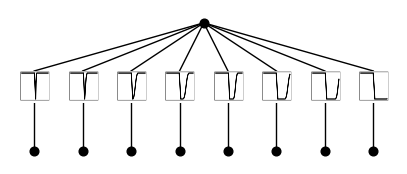

In [8]:
model2.plot(beta=1000)

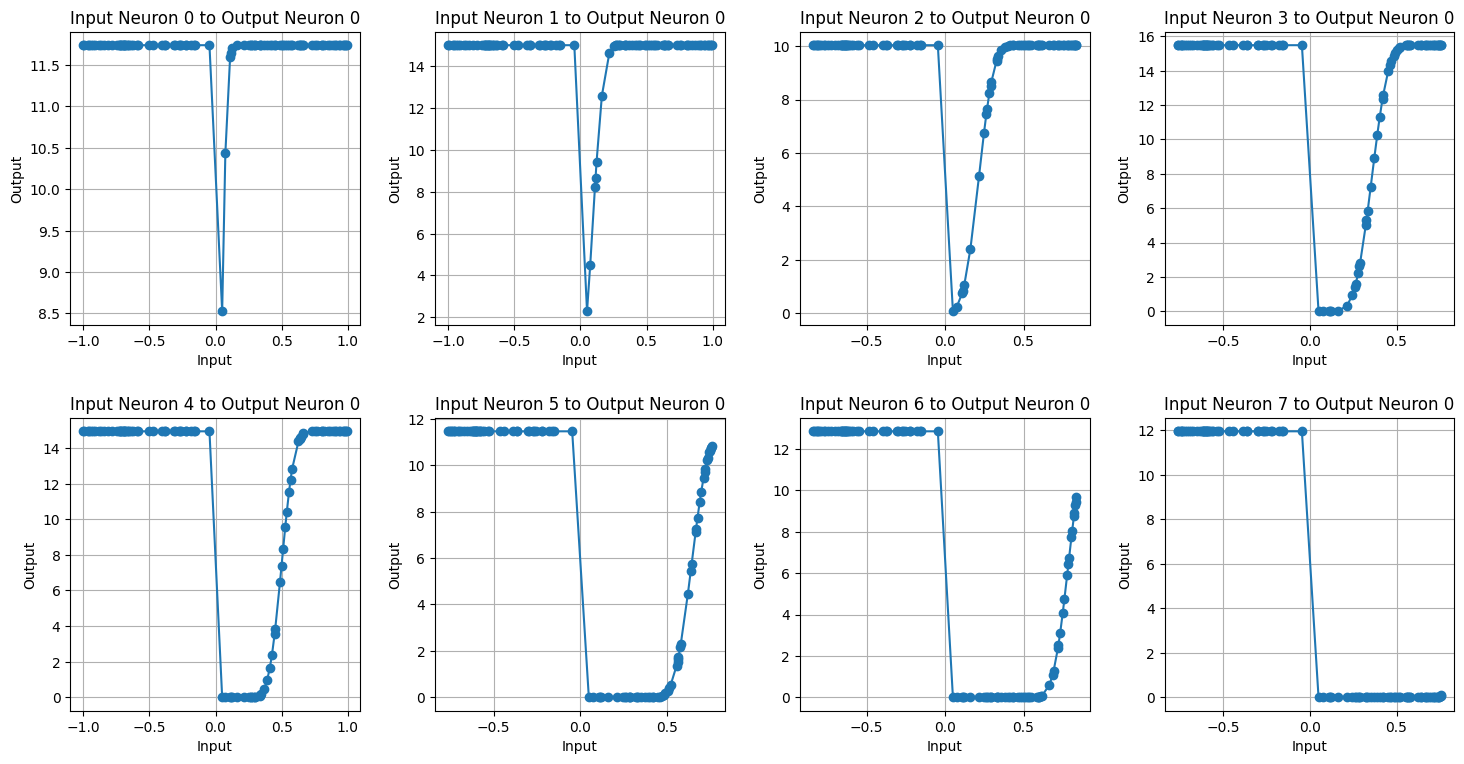

In [10]:
# 8 input neurons
input_neurons = [0, 1, 2, 3, 4, 5, 6, 7]
output_neuron = 0  
layer_index = 0  

rows = 2
cols = 4  

fig, axs = plt.subplots(rows, cols, figsize=(15, 8))

for idx, input_neuron in enumerate(input_neurons):
    # Extract inputs and outputs for each input neuron to the output neuron
    inputs = model2.acts[layer_index][:, input_neuron].cpu() 
    outputs = model2.spline_postsplines[layer_index][:, output_neuron, input_neuron].cpu()

    # Sort the inputs and outputs for proper visualization
    rank = np.argsort(inputs).cpu()
    inputs_sorted = inputs[rank].cpu()
    outputs_sorted = outputs[rank].cpu()

    row_idx = idx // cols
    col_idx = idx % cols
    ax = axs[row_idx, col_idx] 

    ax.plot(inputs_sorted, outputs_sorted, marker="o")
    ax.set_title(f'Input Neuron {input_neuron} to Output Neuron {output_neuron}')
    ax.set_xlabel('Input')
    ax.set_ylabel('Output')
    ax.grid(True)

for idx in range(len(input_neurons), rows * cols):
    fig.delaxes(axs[idx // cols, idx % cols])

plt.tight_layout(pad=2.0)
plt.show()


Testing with one hidden layer

In [19]:
model3 = KAN(width=[8, 3, 1], grid=7, k=3, seed=0)  

In [ ]:
results3 = model3.train(
    {'train_input': train_input, 'train_label': train_label, 'test_input': val_input, 'test_label': val_label},
    opt="LBFGS", steps=10, stop_grid_update_step=50, lamb=0, lamb_l1=0.011, lamb_entropy=0.001,
    loss_fn=torch.nn.MSELoss(), # MSELoss for regression
    lr= 1e-4, batch=25
)

In [ ]:
model.plot(scale=1, beta=100000)